In [1]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

TIMESTEP_IN_REPLICA = 101
TEMPERATURE = 303.15

gleap_target = md.load("../2_md-preparation/gleap.target.gro")
protein_indices = gleap_target.topology.select("resid 5 to 48")
fluctuatig_region_indices = gleap_target.topology.select("resid 5 to 14")
rigid_region_indices = gleap_target.topology.select("resid 15 to 48")
rna_indices = gleap_target.topology.select("resid 0 to 4")

pacs_idr_ca_position_vectors = [[] for _ in range(32)]
for trial in range(len(pacs_idr_ca_position_vectors)):
    xtc = md.load(f"./trial{str(trial+1).zfill(3)}/prd.target.trjcat-all.mol.pbc.xtc", top = "../2_md-preparation/gleap.target.gro")
    xtc.superpose(gleap_target, atom_indices=rigid_region_indices, ref_atom_indices=rigid_region_indices)
    print(trial, xtc.n_frames)
    
    protein_coms = md.compute_center_of_mass(xtc.atom_slice(protein_indices))
    rna_coms     = md.compute_center_of_mass(xtc.atom_slice(    rna_indices))

    idr_ca_position_vector = xtc.atom_slice(gleap_target.topology.select("name CA or name \"C3\'\"")).xyz.reshape((xtc.n_frames, 138))
    com_dists = np.linalg.norm(rna_coms-protein_coms, axis=1)
    for i in range(len(com_dists)):
        if np.max(com_dists[i]) < 1.5:
            pacs_idr_ca_position_vectors[trial].append(idr_ca_position_vector[i])

for trial in range(len(pacs_idr_ca_position_vectors)):
    pacs_idr_ca_position_vectors[trial] = np.array(pacs_idr_ca_position_vectors[trial])
    print(trial, pacs_idr_ca_position_vectors[trial].shape)

0 666398
1 437027
2 607111
3 482376
4 305020
5 292698
6 423998
7 387537
8 340774
9 264923
10 313908
11 212807
12 495405
13 297344
14 249672
15 286335
16 219473
17 204222
18 155742
19 135441
20 316736
21 173316
22 277649
23 200889
24 257348
25 205838
26 186749
27 289668
28 275932
29 174528
30 176447
31 202505
0 (441852, 138)
1 (307101, 138)
2 (198537, 138)
3 (163533, 138)
4 (116258, 138)
5 (155939, 138)
6 (178632, 138)
7 (212743, 138)
8 (172617, 138)
9 (131494, 138)
10 (167658, 138)
11 (89005, 138)
12 (158451, 138)
13 (129687, 138)
14 (114492, 138)
15 (77808, 138)
16 (34610, 138)
17 (69485, 138)
18 (29496, 138)
19 (21532, 138)
20 (47641, 138)
21 (42110, 138)
22 (48329, 138)
23 (46105, 138)
24 (100011, 138)
25 (62580, 138)
26 (26410, 138)
27 (62064, 138)
28 (50092, 138)
29 (34563, 138)
30 (65398, 138)
31 (24429, 138)


[0.52585128 0.16964567]


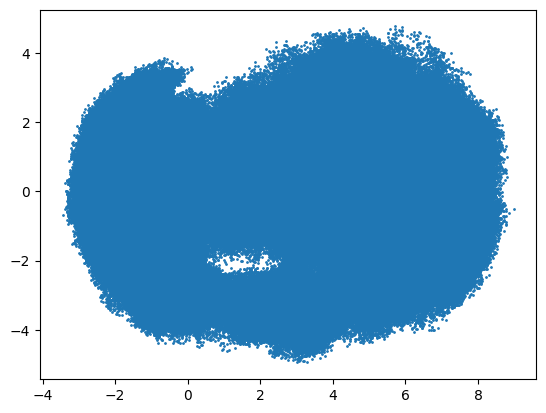

In [2]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver="full")
projected = pca.fit_transform(np.concatenate(pacs_idr_ca_position_vectors))
print(pca.explained_variance_ratio_)

projected[:,0]*=-1
plt.scatter(projected[:,0], projected[:,1], s=1)

100 finished
80 finished
60 finished
40 finished
20 finished


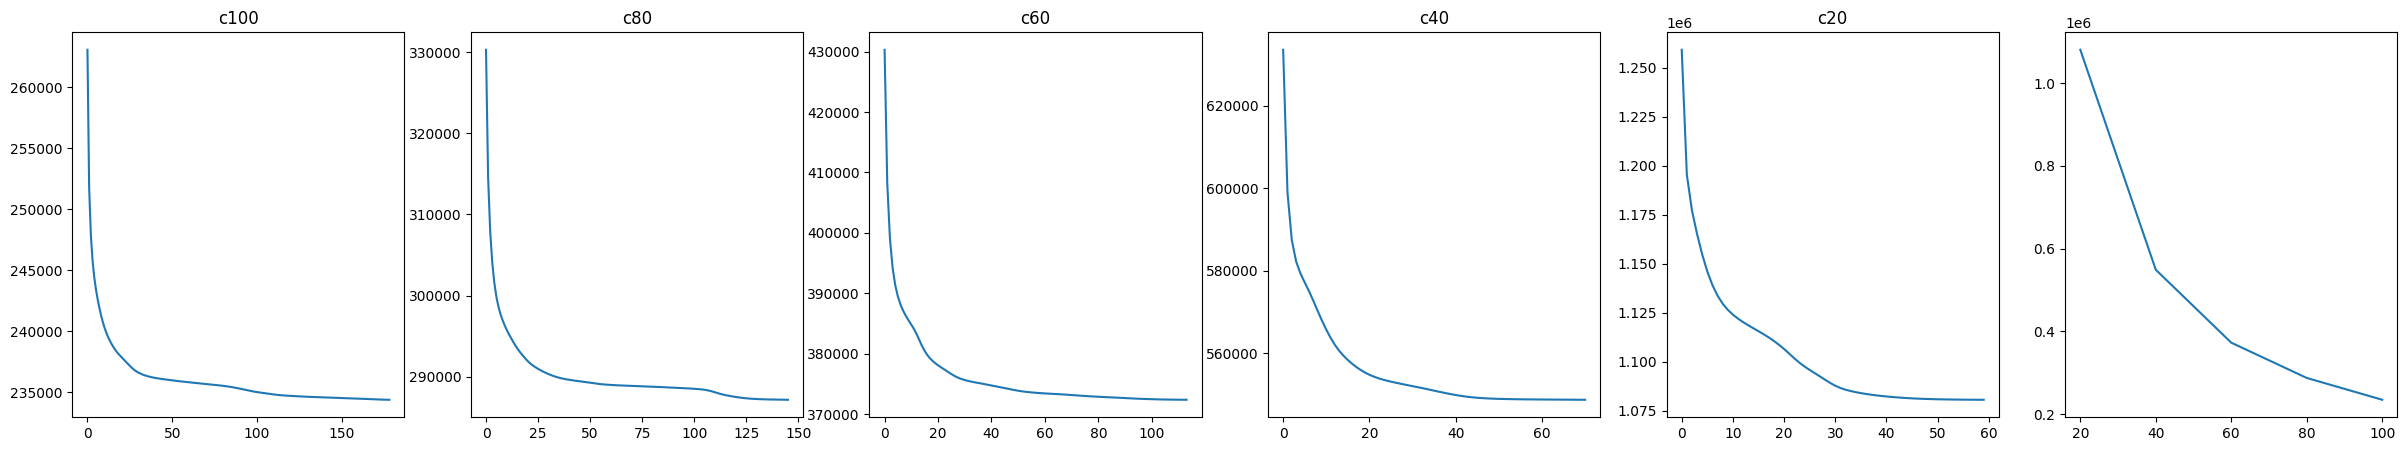

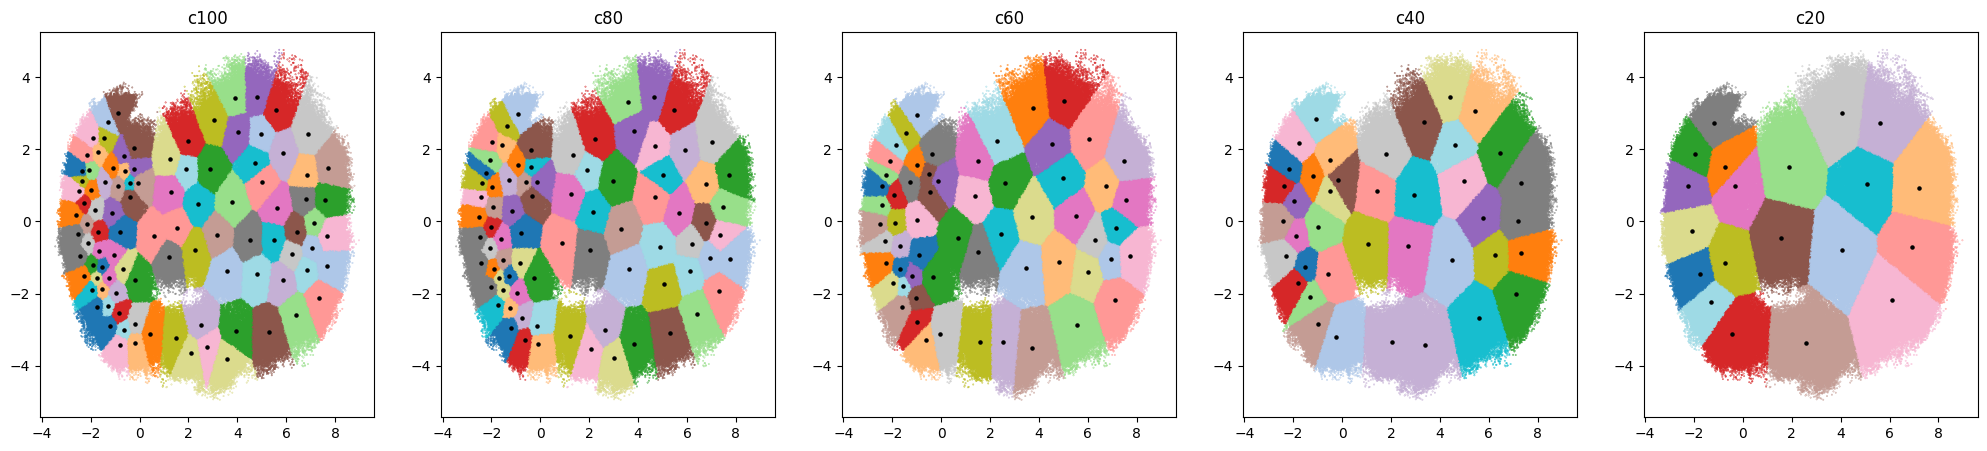

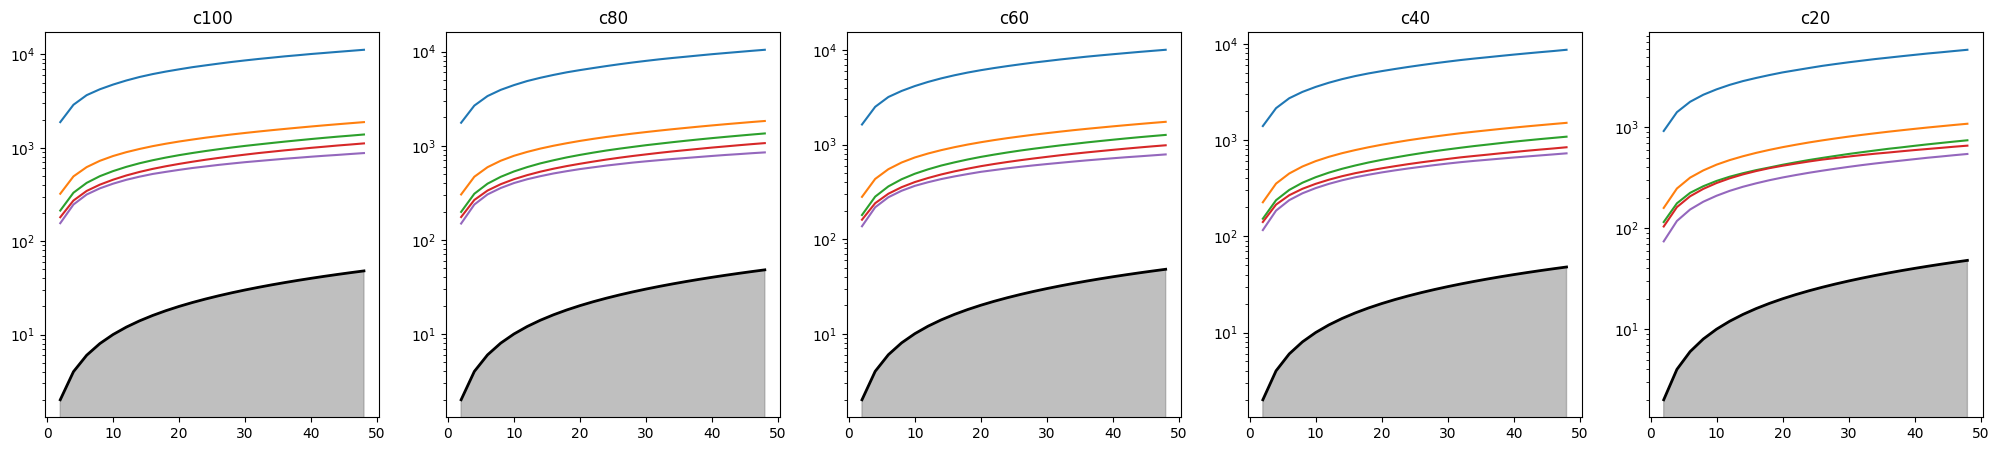

In [3]:
from deeptime.clustering import KMeans
import matplotlib
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import MaximumLikelihoodMSM
from deeptime.markov.msm import BayesianMSM
from deeptime.markov.tools import estimation
from deeptime.util.validation import implied_timescales
from deeptime.plots import plot_implied_timescales

n_clusters_candidates = [100, 80, 60, 40, 20]

fig_inertias, ax_inertias = plt.subplots(1, len(n_clusters_candidates)+1)
fig_inertias.set_size_inches(5*(len(n_clusters_candidates)+1), 5)

fig_cluster, ax_cluster = plt.subplots(1, len(n_clusters_candidates))
fig_cluster.set_size_inches(5*len(n_clusters_candidates), 5)

fig_its, ax_its = plt.subplots(1, len(n_clusters_candidates))
fig_its.set_size_inches(5*len(n_clusters_candidates), 5)

clustering_models = {}
msm_models = {}
pmfs = {}
stationary_distributions = {}

trajs = []
for traj in pacs_idr_ca_position_vectors:
    transformed_traj = pca.transform(traj)
    transformed_traj[:,0]*=-1
    trajs.append(transformed_traj)
trajs_concat = np.concatenate(trajs)

cluster_candidate_inertias = {}
for i_n_clusters in range(len(n_clusters_candidates)):
    n_clusters = n_clusters_candidates[i_n_clusters]
    msm_models[n_clusters] = {}
    pmfs[n_clusters] = {}
    stationary_distributions[n_clusters] = {}

    cluster_builder = KMeans(
        n_clusters=n_clusters,
        fixed_seed=1,
        max_iter=1000,
        metric="euclidean",
        tolerance=1e-5,
        init_strategy="kmeans++",
        initial_centers=None,
        progress=None,
    )
    cluster_builder.fit(trajs_concat)
    clustering_model = cluster_builder.fetch_model()
    clustered_trajs = [cluster_builder.transform(traj) for traj in trajs]
    clustering_models[n_clusters] = clustering_model
    ax_inertias[i_n_clusters].plot(clustering_model.inertias)
    ax_inertias[i_n_clusters].set_title(f"c{n_clusters}")
    cluster_candidate_inertias[n_clusters] = clustering_model.inertia
    ax_cluster[i_n_clusters].set_title(f"c{n_clusters}")
    trajs_concat_clustered = clustering_model.transform(trajs_concat)
    ax_cluster[i_n_clusters].scatter(trajs_concat[:,0], trajs_concat[:,1], s=0.1, c=[matplotlib.cm.tab20(i%20) for i in trajs_concat_clustered])
    for cluster_center in clustering_model.cluster_centers:
        ax_cluster[i_n_clusters].scatter(cluster_center[0], cluster_center[1], color="black", s=5)

    for lagtime in range(2, int(TIMESTEP_IN_REPLICA/2), 2):
        count_builder = TransitionCountEstimator(
            lagtime=lagtime,
            count_mode="sliding",
            n_states=None,
            sparse=False,
        )
        count_builder.fit(clustered_trajs)
        count_model = count_builder.fetch_model()

        msm_builder = MaximumLikelihoodMSM(
            reversible=True,
            stationary_distribution_constraint=None,
            sparse=False,
            allow_disconnected=False,
            maxiter=1000000,
            maxerr=1e-12,
            connectivity_threshold=0,
            transition_matrix_tolerance=1e-12,
            lagtime=None,
            use_lcc=False,
        )

        try:
            msm_builder.fit(count_model)
        except Exception as e:
            print("msm ng", n_clusters, lagtime, e)
            continue
        msm_model = msm_builder.fetch_model()
        if len(clustering_model.cluster_centers) != msm_model.n_states:
            print("n_states and n_cluster different", n_clusters, lagtime)
        msm_models[n_clusters][lagtime] = msm_model

        largest_connected_set = estimation.largest_connected_set(count_model.count_matrix, directed=True)
        stationary_distribution = np.zeros(clustering_model.n_clusters)
        stationary_distribution[largest_connected_set] = msm_model.stationary_distribution
        stationary_distributions[n_clusters][lagtime] = stationary_distribution

        pmfs[n_clusters][lagtime] = np.zeros(len(stationary_distribution))
        for i_state, distribution in enumerate(stationary_distribution):
            pmfs[i_state] = -np.log(distribution/max(stationary_distribution))
        pmfs[n_clusters][lagtime] *= 1.38e-23
        pmfs[n_clusters][lagtime] *= TEMPERATURE
        pmfs[n_clusters][lagtime] *= 6.02e23
        pmfs[n_clusters][lagtime] /= 4.19*1000

    its = implied_timescales([model for model in msm_models[n_clusters].values()])
    plot_implied_timescales(
        its,
        n_its=5,
        ax=ax_its[i_n_clusters],
        process=None,
        show_mle=True,
        show_sample_mean=True,
        show_sample_confidence=True,
        show_cutoff=True,
        sample_confidence=0.95,
        colors=None,
    )
    ax_its[i_n_clusters].set_yscale('log')
    ax_its[i_n_clusters].set_title(f"c{n_clusters}")
    print(n_clusters, "finished")
ax_inertias[-1].plot(cluster_candidate_inertias.keys(), cluster_candidate_inertias.values())

In [4]:
from deeptime.util import energy2d

n_clusters = 40
lagtime = 30

bound_structures_pca = np.zeros((len(pacs_idr_ca_position_vectors), 2))
for trial in range(len(pacs_idr_ca_position_vectors)):
    transformed = pca.transform(pacs_idr_ca_position_vectors[trial])
    bound_structures_pca[trial] = np.average(transformed, axis=0)
bound_structures_pca[:,0]*=-1

dtrajs = [clustering_models[n_clusters].transform(traj) for traj in trajs]
weights = msm_models[n_clusters][lagtime].compute_trajectory_weights(np.concatenate(dtrajs))[0]

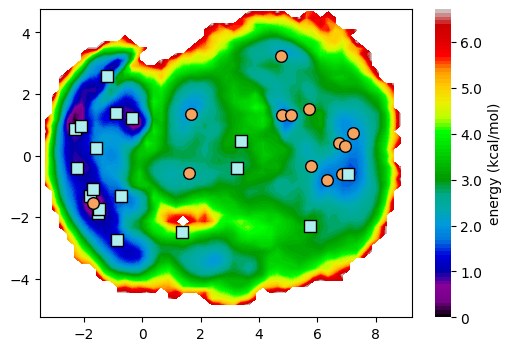

In [62]:
pacs_g_stds_ordered = [(19, -3.4383222715529755), (18, -4.064455225716387), (30, -4.48612942287419), (26, -4.624781171615315), (29, -4.683410979897177), (25, -4.933236290336003), (17, -5.118835703750063), (23, -5.521004724688876), (20, -5.522645853979005), (28, -5.678007148970815), (3, -5.678261127542603), (22, -5.93031226290956), (24, -5.966115973285376), (21, -6.022353770917038), (4, -6.125216702283895), (31, -6.224672440089437), (16, -6.2739255360777175), (11, -6.287913880137764), (7, -6.520357463407324), (2, -6.873004446601907), (5, -7.305598346706374), (15, -7.425622465131511), (9, -7.442437949729127), (8, -7.627195073788825), (1, -8.100851065532183), (10, -8.265797922888845), (12, -8.413117936507568), (27, -8.424109846287314), (13, -9.041054919020613), (14, -9.094471340851847), (6, -9.28998243345896), (0, -10.433896108969531)]
unstable_trials = [19,18,30,26,29,25,17,23,20,28,3,22,24,21,4,31,16,11,7,2,5,15,9,8,1,10,12,27,13,14,6,0][:13]
stable_trials = [val for val in range(32) if not val in unstable_trials]

kbt  = 1.38e-23
kbt *= 303.15
kbt *= 6.02e23
kbt /= 4.19*1000

energies = energy2d(*trajs_concat.T, bins=(50, 50), kbt=kbt, weights=weights, shift_energy=True)
ax, contour, cbar = energies.plot(contourf_kws=dict(cmap='nipy_spectral'))
cbar.set_ticks(ticks=[0, 1, 2, 3, 4, 5, 6,], labels=[0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0])
ax.figure.set_size_inches(6, 4)
ax.set_ylim(-5.25, 4.75)
ax.set_xlim(-3.5, 9.25)
cbar.set_label('energy (kcal/mol)')
# ax.set_xticks([-0.5, 0, 1, 2, 2.5], [-0.5, 0, 1, 2, 2.5])

for trial in range(len(bound_structures_pca)-1, 0, -1):
    pca_x, pca_y = bound_structures_pca[trial]
    color = "paleturquoise"
    marker="s"
    if trial+1 in unstable_trials:
        color = "sandybrown"
        marker="o"
    ax.scatter(pca_x, pca_y, s=70, c=color, marker=marker, edgecolors='black')
    # ax.annotate(trial+1, (pca_x, pca_y), c="black")

1 0.20210209499034548
2 0.44596472782022856
3 0.23270387999439826
4 4.019182386911464
5 1.2973419566612734
6 0.5909288653927306
7 0.7844291859239066
8 1.3031646623241173
9 0.4103190734647761
10 1.188664233539454
11 0.5504239517453344
12 0.5909288653927306
13 1.0720307857103795
14 1.0724701220855029
15 0.5504239517453344
16 1.488678227965581
17 2.5291499802369044
18 2.210005218079597
19 1.931518168742636
20 1.6256045664284666
21 1.6485800846781786
22 2.005730934194021
23 1.7415143979915473
24 2.6679853211636115
25 2.4100555479204524
26 2.880242237043834
27 2.752102318333312
28 2.445117924923997
29 1.757432912002976
30 2.251885221257018
31 3.1179624166521185
32 3.3180161765504743


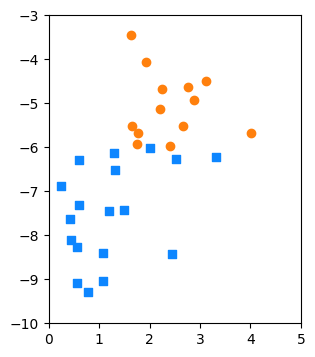

In [53]:
xy = []

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3.25, 4)
ax.set_ylim(-10, -3)
ax.set_xlim(0,  5)
ax.set_xticks([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5])

trial_energies = np.zeros(32)
for trial in range(len(bound_structures_pca)):
    isp = bound_structures_pca[trial]
    for x_i in range(len(energies.x_meshgrid)):
        for y_i in range(len(energies.y_meshgrid)):
            if energies.x_meshgrid[x_i] <= isp[0] <= energies.x_meshgrid[x_i+1] and energies.y_meshgrid[y_i] <= isp[1] <= energies.y_meshgrid[y_i+1]:
                print(trial+1, energies.energies[y_i][x_i])
                trial_energies[trial] = energies.energies[y_i][x_i]
                for g_trial, g_std in pacs_g_stds_ordered:
                    if g_trial == trial:
                        color = "#0D86FF"
                        marker="s"
                        if trial in unstable_trials:
                            color = "#FF800D"
                            marker="o"
                        ax.scatter(energies.energies[y_i][x_i], g_std, label=trial+1, c=color, marker=marker)
                        xy.append((energies.energies[y_i][x_i], g_std))
# plt.legend()

In [7]:
correlation_matrix = np.corrcoef(np.array(xy)[:,0], np.array(xy)[:,1])
print(correlation_matrix)

[[1.         0.62683169]
 [0.62683169 1.        ]]


2
[[0.99650386 0.00349614]
 [0.00107543 0.99892457]]
[0.23524304 0.76475696]
27895.84758238572
8580.901466726642
!!!


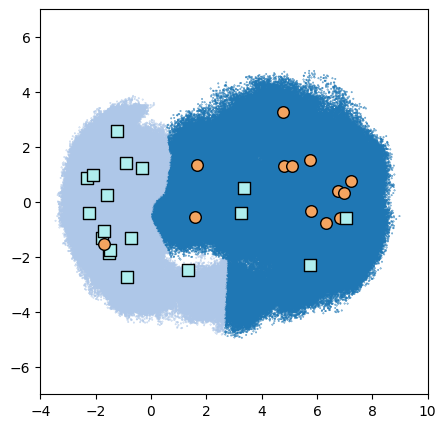

In [109]:
from deeptime.markov.tools.analysis import mfpt
import deeptime

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 5)

for n_metastable_sets in range(2, 3):
    print(n_metastable_sets)
    pcca = msm_models[n_clusters][lagtime].pcca(n_metastable_sets=n_metastable_sets)
    # print(pcca.get_params())
    print(pcca.coarse_grained_transition_matrix)
    print(pcca.coarse_grained_stationary_probability)
    print(mfpt(pcca.coarse_grained_transition_matrix, 0, origin=1, tau=lagtime, mu=pcca.coarse_grained_stationary_probability))
    print(mfpt(pcca.coarse_grained_transition_matrix, 1, origin=0, tau=lagtime, mu=pcca.coarse_grained_stationary_probability))
    print("!!!")
    
    colors = [None for _ in range(len(trajs_concat))]
    for i, cluster_index in enumerate(clustering_models[n_clusters].transform(trajs_concat)):
        colors[i] =  matplotlib.cm.tab20(np.argmax(pcca.memberships[cluster_index]))
    ax.scatter(*trajs_concat.T, color=colors, s=0.1)
ax.set_ylim(-7, 7)
ax.set_xlim(-4, 10)

for trial in range(len(bound_structures_pca)-1, 0, -1):
    pca_x, pca_y = bound_structures_pca[trial]
    color = "paleturquoise"
    marker="s"
    if trial+1 in unstable_trials:
        color = "sandybrown"
        marker="o"
    ax.scatter(pca_x, pca_y, s=70, c=color, marker=marker, edgecolors='black')

In [60]:
print(trial_energies)

trial_probabilities = np.exp(-trial_energies*1000*4.18/8.314/303.15)
trial_probabilities /= np.sum(trial_probabilities)
print(trial_probabilities)

weighted_energy = 0
for g_trial, g_std in pacs_g_stds_ordered:
    weighted_energy += g_std*trial_probabilities[g_trial]
print(weighted_energy)

[0.20210209 0.44596473 0.23270388 4.01918239 1.29734196 0.59092887
 0.78442919 1.30316466 0.41031907 1.18866423 0.55042395 0.59092887
 1.07203079 1.07247012 0.55042395 1.48867823 2.52914998 2.21000522
 1.93151817 1.62560457 1.64858008 2.00573093 1.7415144  2.66798532
 2.41005555 2.88024224 2.75210232 2.44511792 1.75743291 2.25188522
 3.11796242 3.31801618]
[0.13102591 0.08744021 0.12454198 0.00023337 0.02130556 0.06875407
 0.04988003 0.02110081 0.0927653  0.02551349 0.07353138 0.06875407
 0.03095829 0.03093574 0.07353138 0.01551243 0.00276225 0.00468956
 0.00744247 0.01236108 0.01189893 0.00658058 0.01019931 0.00219414
 0.00336545 0.00154306 0.00190844 0.00317533 0.00993356 0.0043749
 0.00104031 0.00074657]
-7.869618902485285


In [74]:
weighted_energy = 0
for g_trial, g_std in pacs_g_stds_ordered:
    weighted_energy += g_std*trial_probabilities[g_trial]
print(weighted_energy)

-7.869618902485285


In [75]:
weighted_variance = 0
for g_trial, g_std in pacs_g_stds_ordered:
    weighted_variance += np.power(g_std-weighted_energy, 2)*trial_probabilities[g_trial]
weighted_std = np.sqrt(weighted_variance)
print(weighted_std)

1.5031721357030916
